## VAE and InfoVAE on a simplistic Gaussian Mixture problem

In [22]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import torch
import torch.nn as nn
import torch.utils.data as tdata

import vaes_ptorch.args as args
import vaes_ptorch.models as models
import vaes_ptorch.proba as proba
import vaes_ptorch.train_vae as train_vae
import vaes_ptorch.vae as vae_nn

In [23]:
data = np.array([[1.0], [-1.0]])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

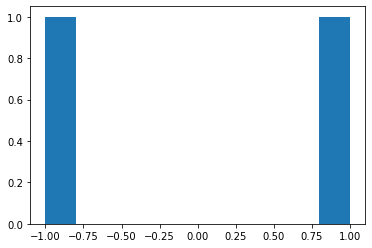

In [24]:
plt.hist(data.flatten())

In [26]:
data_dim = 1
latent_dim = 1

h_size = 128
h_layers = 3

lr = 1e-3
batch_size = 2
num_epochs = 1000

print_every = 100

info_vae = True
# info_vae = False
# start_scale = 500.0
# end_scale = 500.0
start_scale = 0.0
end_scale = 1.0
start_epochs = 200
linear_epochs = 300

In [27]:
dataset = tdata.TensorDataset(torch.from_numpy(data).float())
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True
)

In [28]:
encoder = models.GaussianNN(
    model=models.get_mlp(
        in_dim=data_dim,
        out_dim=2 * latent_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    ),
    out_dim=latent_dim,
    min_var=1e-2,
)
decoder = models.GaussianNN(
    model=models.get_mlp(
        in_dim=latent_dim,
        out_dim=2 * data_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    ),
    out_dim=data_dim,
    min_var=1e-2,
)
vae = vae_nn.GaussianVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    stats_model=proba.GaussianModel(),
)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = args.TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=args.DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    smoothing=0.9,
)

In [29]:
train_vae.train(
    train_data=dataloader, vae=vae, optimizer=optimizer, train_args=train_args
)

Step: 0 | Training loss: 0.76366 | Div scale: 0.000
NLL: 0.76366 | Divergence.MMD: 91.67932
Step: 100 | Training loss: 0.39170 | Div scale: 0.000
NLL: 0.63727 | Divergence.MMD: 244.91388
Step: 200 | Training loss: 0.13341 | Div scale: 0.003
NLL: -0.09677 | Divergence.MMD: 152.77594
Step: 300 | Training loss: 15.52159 | Div scale: 0.337
NLL: 0.35679 | Divergence.MMD: 54.93018
Step: 400 | Training loss: 32.23977 | Div scale: 0.670
NLL: -0.66692 | Divergence.MMD: 87.26721
Step: 500 | Training loss: 33.00774 | Div scale: 1.000
NLL: -0.30334 | Divergence.MMD: 34.42993
Step: 600 | Training loss: 39.64750 | Div scale: 1.000
NLL: -1.50321 | Divergence.MMD: 73.08665
Step: 700 | Training loss: 34.02329 | Div scale: 1.000
NLL: -2.13169 | Divergence.MMD: 47.53582
Step: 800 | Training loss: 36.46675 | Div scale: 1.000
NLL: -2.24950 | Divergence.MMD: 27.36512
Step: 900 | Training loss: 31.54934 | Div scale: 1.000
NLL: -2.26200 | Divergence.MMD: 17.64704


Results(train_ewma=37.65423605721069, eval_ewma=None)

### Looking at the input space

First, we look at the approximate data distribution:
- $p_{\theta}(x) = \int_z p(z) p_{\theta}(x| z) dz$

Second, we look at the reconstruction distributions:
- $p_{\theta, 1}(x) = \int_z q_{\phi}(z| x = 1)p_{\theta}(x | z)dz$
- $p_{\theta, -1}(x) = \int_z q_{\phi}(z| x = -1)p_{\theta}(x | z)dz$

In [30]:
def plot_pdf(xs, zs, conditional_dist, label):
    mu, var = conditional_dist(zs)
    mu, var = mu.detach().numpy(), var.detach().numpy()
    pdf = np.zeros_like(xs)
    for i in range(mu.shape[0]):
        pdf_i = sts.norm.pdf(xs, loc=mu[i], scale=np.sqrt(var[i]))
        pdf += pdf_i
    pdf /= mu.shape[0]
    plt.plot(xs, pdf, label=label)


n_monte_carlo_samples = 5000

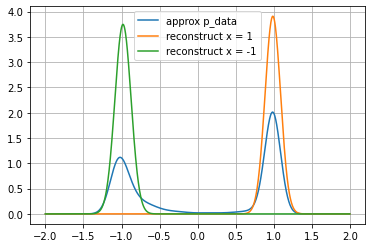

In [31]:
x_grid = np.linspace(-2.0, 2.0, num=1000)
mu_z1, var_z1 = vae.encoder(torch.ones((1, 1)))
z1_samples = (
    torch.randn((n_monte_carlo_samples, 1)) * torch.sqrt(var_z1) + mu_z1
)
mu_z_1, var_z_1 = vae.encoder(-torch.ones((1, 1)))
z_1_samples = (
    torch.randn((n_monte_carlo_samples, 1)) * torch.sqrt(var_z_1) + mu_z_1
)
z_samples = torch.randn((n_monte_carlo_samples, 1))

vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf(x_grid, z_samples, vae.decoder, "approx p_data")
    plot_pdf(x_grid, z1_samples, vae.decoder, "reconstruct x = 1")
    plot_pdf(x_grid, z_1_samples, vae.decoder, "reconstruct x = -1")
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

### Looking at the latent space
First, we look at the approximate prior distribution:
- $q_{\phi}(z) = \frac{1}{2} q_{\phi}(z | x = -1) + \frac{1}{2} + q_{\phi}(z| x = 1)$

Second, we look at the approximate posterior distributions:
- $q_{\phi}(z | x = -1)$
- $q_{\phi}(z | x = 1)$

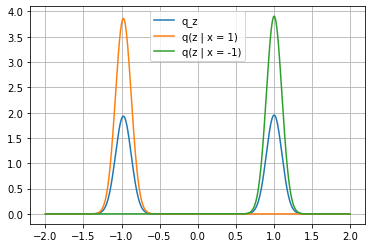

In [32]:
z_grid = np.linspace(-2, 2.0, num=1000)
vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf(z_grid, torch.from_numpy(data).float(), vae.decoder, "q_z")
    plot_pdf(z_grid, torch.ones((1, 1)), vae.decoder, "q(z | x = 1)")
    plot_pdf(z_grid, -torch.ones((1, 1)), vae.decoder, "q(z | x = -1)")
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()